In [96]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
data = pd.read_csv('clean_data.csv')

In [98]:
data.iloc[:,1:].head(20)

,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour
0,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0
1,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0
2,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1
3,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1
4,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1
5,2018-01-01 02:20:14,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,02:20:14,1,2
6,2018-01-01 02:40:41,97402,5,CHECK WELFARE,CAHOOT,2018,1,02:40:41,1,2
7,2018-01-01 02:55:45,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,02:55:45,1,2
8,2018-01-01 03:12:44,97401,7,CHECK WELFARE,CAHOOT,2018,1,03:12:44,1,3
9,2018-01-01 04:11:55,97402,3,OTHER,CAHOOT,2018,1,04:11:55,1,4


Part 1: Graph visualizations as a function of call volume through time to see if there is any obvious visual trends through the call volume

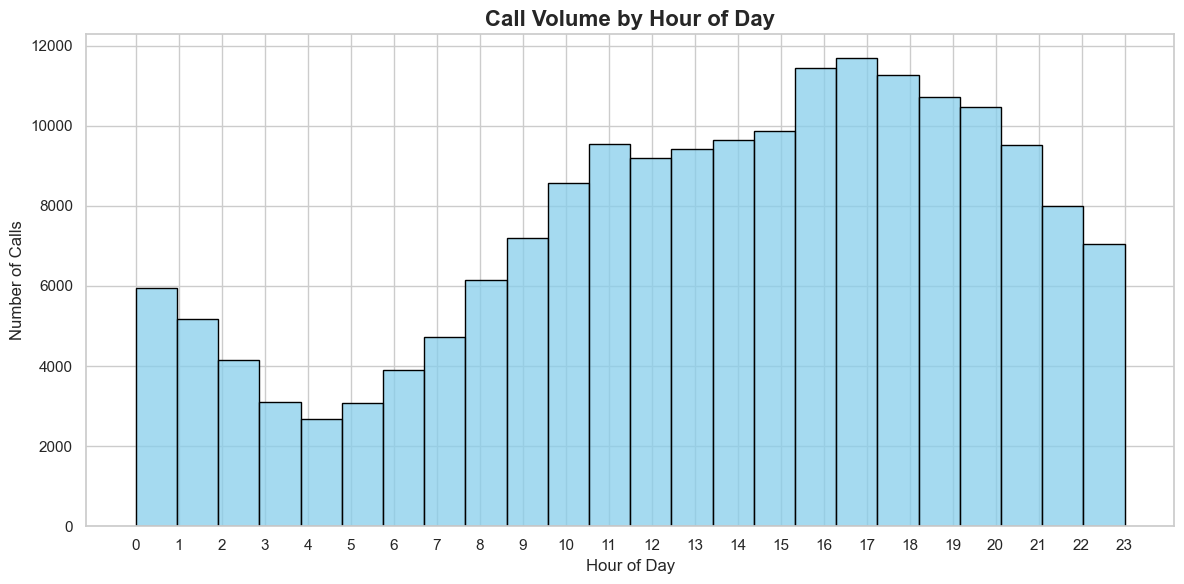

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.histplot(
    data,
    x='Call_Hour',
    bins=24,
    color='skyblue',
    edgecolor='black'
)

plt.title('Call Volume by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Calls', fontsize=12)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


<Axes: xlabel='Call_Day', ylabel='Count'>

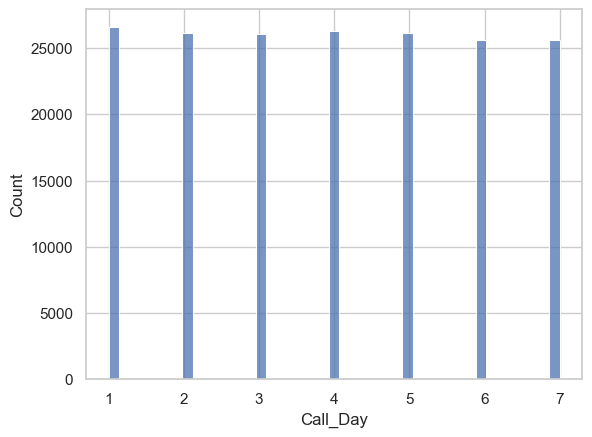

In [100]:
sns.histplot(data,x='Call_Day')

<Axes: xlabel='Call_Month', ylabel='Count'>

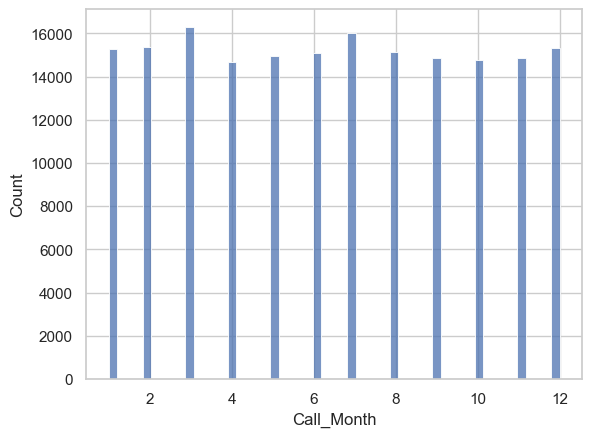

In [101]:
sns.histplot(data,x='Call_Month')


In [102]:
grouped_hour_month = data.groupby(['Call_Hour', 'Call_Month']).size().reset_index(name='Count')

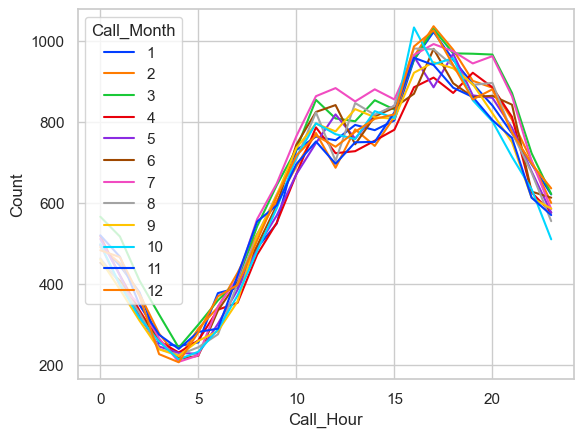

In [103]:
sns.lineplot(data=grouped_hour_month, x='Call_Hour', y='Count', hue='Call_Month', palette='bright')
plt.show()

<Axes: xlabel='Call_Hour', ylabel='Count'>

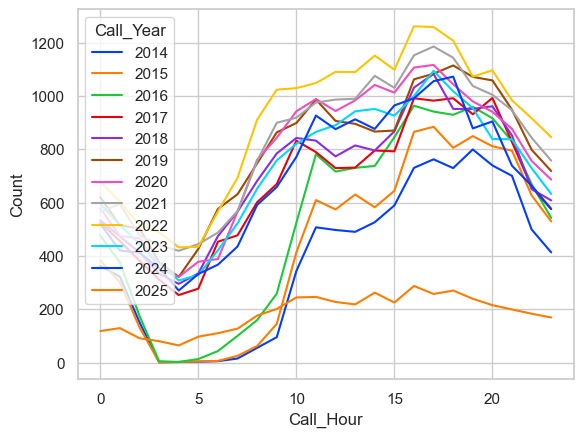

In [104]:
grouped_hour_year = data.groupby(['Call_Hour', 'Call_Year']).size().reset_index(name='Count')
sns.lineplot(data=grouped_hour_year, x='Call_Hour', y='Count', hue='Call_Year', palette='bright')



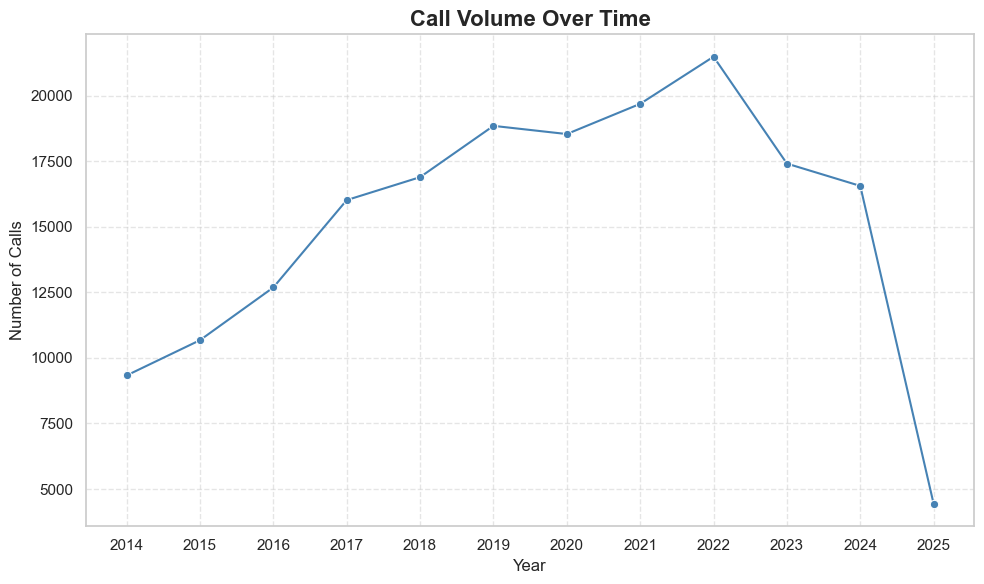

In [105]:
# Prepare data: count calls per year
year_counts = data['Call_Year'].value_counts().sort_index()

# Set theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='steelblue')

# Labels and title
plt.title('Call Volume Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Calls', fontsize=12)
plt.xticks(year_counts.index)  # Ensure all years are shown

# Optional: show grid and tighter spacing
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<Axes: xlabel='Call_Hour', ylabel='Count'>

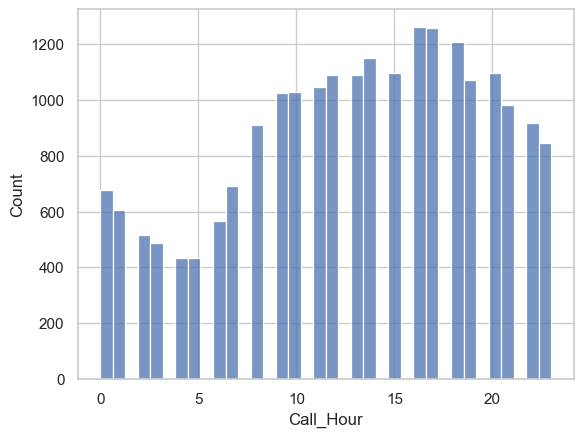

In [106]:
year_2022 = data[data['Call_Year'] == 2022]
sns.histplot(year_2022,x='Call_Hour')

<Axes: xlabel='Call_Month', ylabel='Count'>

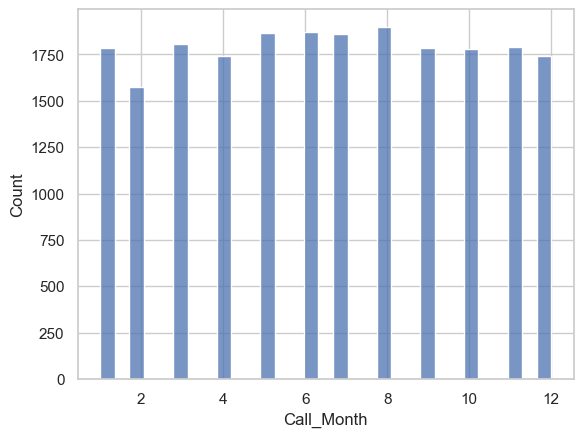

In [107]:
sns.histplot(year_2022,x='Call_Month')


<Axes: xlabel='Call_Hour', ylabel='Count'>

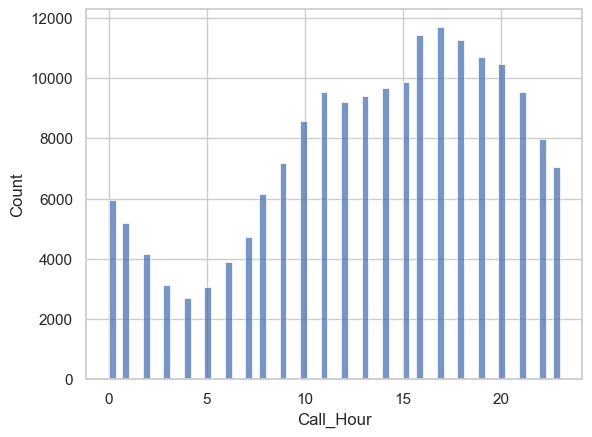

In [108]:
sns.histplot(data,x='Call_Hour')

<Axes: xlabel='Call_Month', ylabel='Count'>

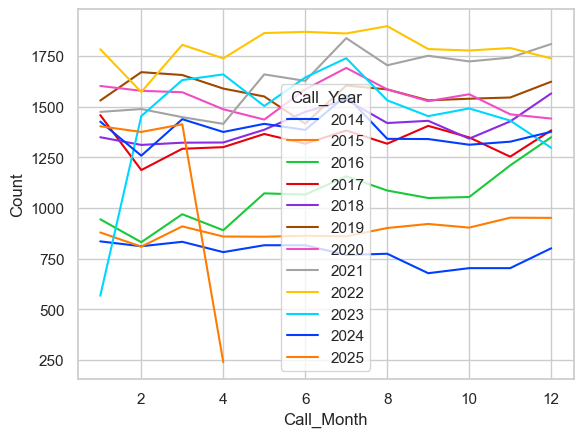

In [109]:
grouped_hour_year = data.groupby(['Call_Month', 'Call_Year']).size().reset_index(name='Count')
sns.lineplot(data=grouped_hour_year, x='Call_Month', y='Count', hue='Call_Year', palette='bright')

From my visualizations I found that there was a slight difference between the call volume in the morning(ish) hours of 9 am to 3 pm and the hours of 4pm to 9pm. I decided to create a t test to see if this difference was actually significant or if it was just a random difference.

In [110]:
def group_hour(hour):
    if 0 <= hour <= 8 or 22 <= hour <= 23:
        return 'Night'
    elif 9 <= hour <= 15:
        return 'Morning'
    elif 16 <= hour <= 21:
        return 'Evening'

data['Call_Hour_Group'] = data['Call_Hour'].apply(group_hour)

In [111]:
data['calltime'] = pd.to_datetime(data['calltime'])

# Create new column with just the date part
data['Call_Date'] = data['calltime'].dt.date

data

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,14,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,27,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,28,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,37,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,38,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182576,1488507,2016-12-31 21:16:44,97401,7,TRANSPORT,CAHOOT,2016,12,21:16:44,6,21,Evening,2016-12-31
182577,1488522,2016-12-31 21:55:13,97401,7,TRANSPORT,CAHOOT,2016,12,21:55:13,6,21,Evening,2016-12-31
182578,1488557,2016-12-31 23:17:05,97402,5,CHECK WELFARE,CAHOOT,2016,12,23:17:05,6,23,Night,2016-12-31
182579,1488574,2016-12-31 23:55:57,97401,7,ASSIST PUBLIC,CAHOOT,2016,12,23:55:57,6,23,Night,2016-12-31


In [112]:
def bootstrap_means(data, n_bootstrap=1000):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    return np.array(bootstrapped_means)

In [113]:
from scipy.stats import ttest_ind

# Step 1: Count calls per hour for each group
grouped = data.groupby(['Call_Date', 'Call_Hour_Group']).size().reset_index(name='Call_Count')

# Step 2: Separate into groups
morning = grouped[grouped['Call_Hour_Group'] == 'Morning']['Call_Count'].values
evening = grouped[grouped['Call_Hour_Group'] == 'Evening']['Call_Count'].values
night = grouped[grouped['Call_Hour_Group'] == 'Night']['Call_Count'].values


# Step 4: Bootstrap both groups
boot_morning = bootstrap_means(morning)
boot_evening = bootstrap_means(evening)
boot_night = bootstrap_means(night)


In [114]:
t_stat, p_val = ttest_ind(boot_evening, boot_morning, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 115.154, P-value: 0.000


In [115]:
t_stat_2, p_val_2 = ttest_ind(boot_morning,boot_night,equal_var=False)
print(f"T-statistic: {t_stat_2:.3f}, P-value: {p_val_2:.3f}")

T-statistic: 569.841, P-value: 0.000


In [116]:
np.mean(boot_night), np.mean(boot_morning), np.mean(boot_evening)

(13.149487454323992, 15.487779594825483, 15.880705853658535)

In [117]:
data.head()

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,14,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,27,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,28,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,37,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,38,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01


I wanted to explore the main call volume by different call types but I found that the two main call types were pretty broad.

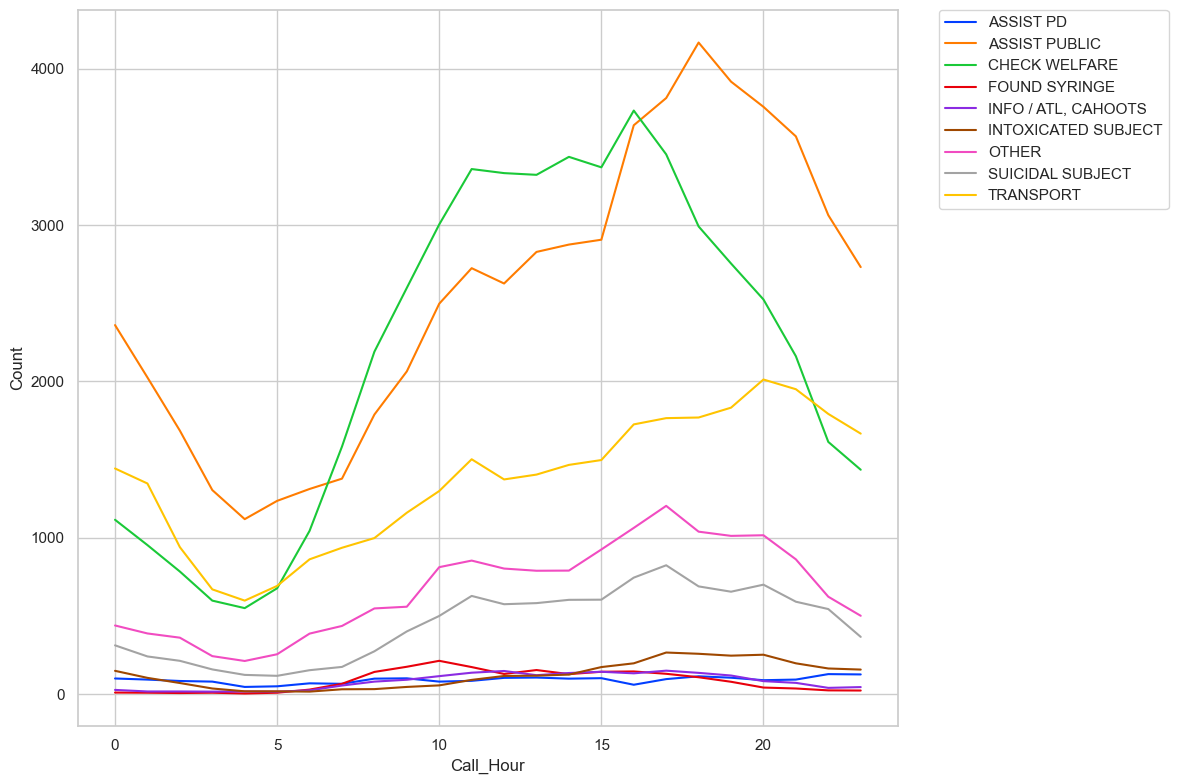

In [118]:
grouped_hour_type = data.groupby(['Call_Hour', 'nature']).size().reset_index(name='Count')
plt.figure(figsize=(12,8))
sns.lineplot(data=grouped_hour_type, x='Call_Hour', y='Count', hue='nature', palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Resize to make room
plt.tight_layout()
plt.show()

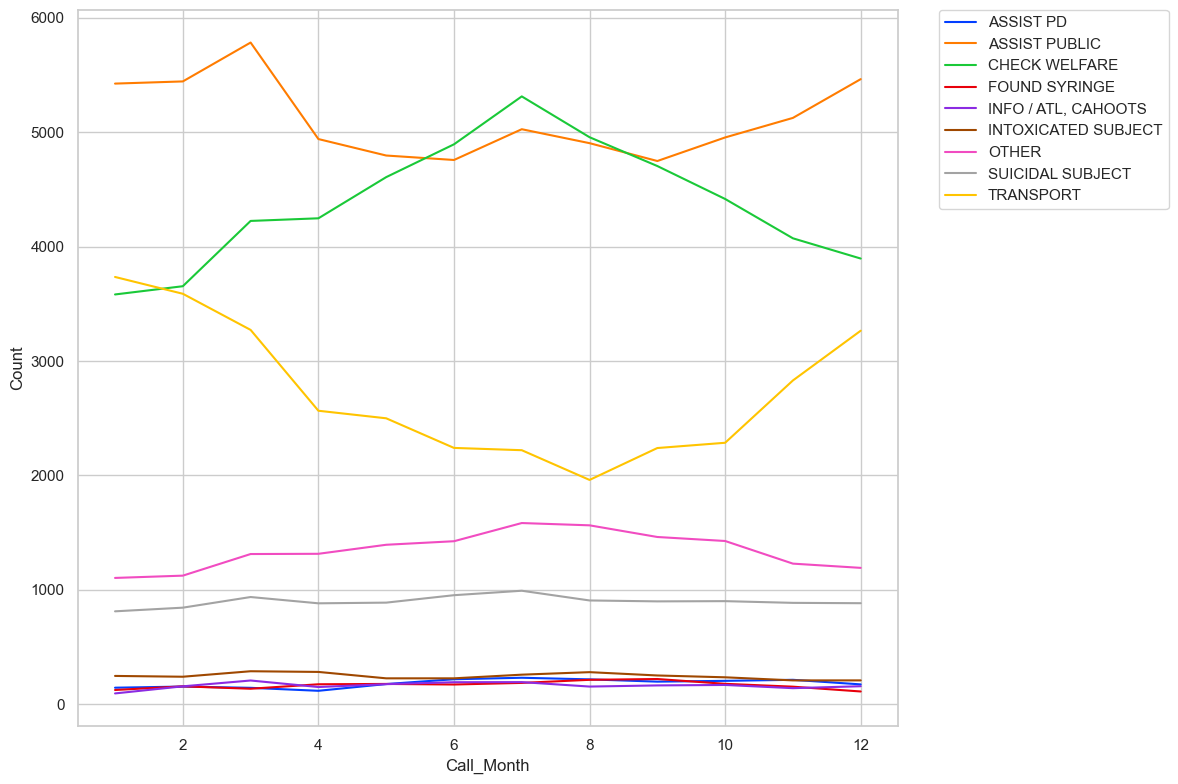

In [119]:
grouped_month_type = data.groupby(['Call_Month', 'nature']).size().reset_index(name='Count')
plt.figure(figsize=(12,8))
sns.lineplot(data=grouped_month_type, x='Call_Month', y='Count', hue='nature', palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Resize to make room
plt.tight_layout()
plt.show()

In [120]:
data

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,14,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,27,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,28,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,37,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,38,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182576,1488507,2016-12-31 21:16:44,97401,7,TRANSPORT,CAHOOT,2016,12,21:16:44,6,21,Evening,2016-12-31
182577,1488522,2016-12-31 21:55:13,97401,7,TRANSPORT,CAHOOT,2016,12,21:55:13,6,21,Evening,2016-12-31
182578,1488557,2016-12-31 23:17:05,97402,5,CHECK WELFARE,CAHOOT,2016,12,23:17:05,6,23,Night,2016-12-31
182579,1488574,2016-12-31 23:55:57,97401,7,ASSIST PUBLIC,CAHOOT,2016,12,23:55:57,6,23,Night,2016-12-31


I then wanted to take a quick look at the calls by zip code but again found that there were only two main ones and they seemed to have very similar trends through the day.

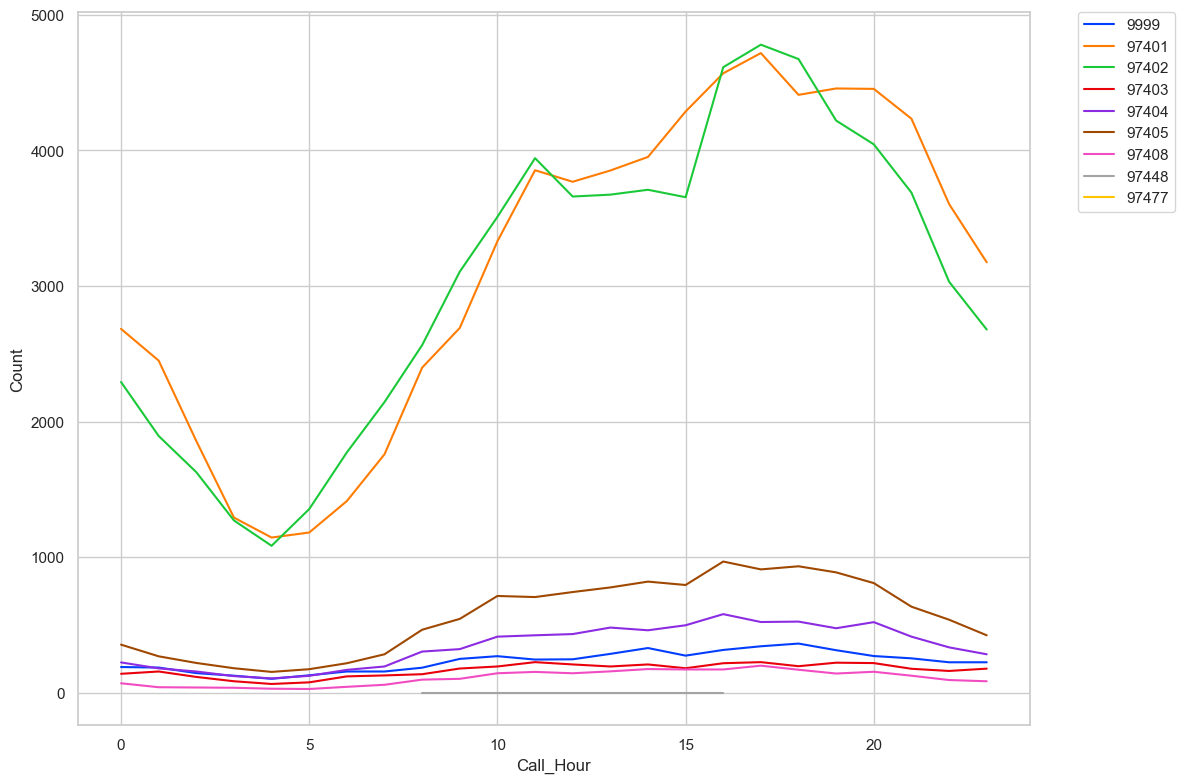

In [121]:
grouped_hour_zip = data.groupby(['Call_Hour', 'zip']).size().reset_index(name='Count')
plt.figure(figsize=(12,8))
sns.lineplot(data=grouped_hour_zip, x='Call_Hour', y='Count', hue='zip', palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Resize to make room
plt.tight_layout()
plt.show()

Further analysis I want to do:

Look at the difference in call volume around when lane county showed up (8/2024)
- MCSLC
- t test on the difference before and after on total call volume per day and also on the top call types per day

- look at when cahoots went offline, what changed for the police
any preventative impacts that cahoots had 

- difference in differences??

In [122]:
data.iloc[:,1:]

,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
182576,2016-12-31 21:16:44,97401,7,TRANSPORT,CAHOOT,2016,12,21:16:44,6,21,Evening,2016-12-31
182577,2016-12-31 21:55:13,97401,7,TRANSPORT,CAHOOT,2016,12,21:55:13,6,21,Evening,2016-12-31
182578,2016-12-31 23:17:05,97402,5,CHECK WELFARE,CAHOOT,2016,12,23:17:05,6,23,Night,2016-12-31
182579,2016-12-31 23:55:57,97401,7,ASSIST PUBLIC,CAHOOT,2016,12,23:55:57,6,23,Night,2016-12-31


In [123]:
data['Call_Date'] = pd.to_datetime(data['Call_Date'])
start_date = '2023-08-01'
end_date = '2025-03-31'

# Filter the data
MCSLC_compare = data[(data['Call_Date'] >= start_date) & (data['Call_Date'] <= end_date)]

In [124]:
data

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,14,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,27,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,28,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,37,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,38,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182576,1488507,2016-12-31 21:16:44,97401,7,TRANSPORT,CAHOOT,2016,12,21:16:44,6,21,Evening,2016-12-31
182577,1488522,2016-12-31 21:55:13,97401,7,TRANSPORT,CAHOOT,2016,12,21:55:13,6,21,Evening,2016-12-31
182578,1488557,2016-12-31 23:17:05,97402,5,CHECK WELFARE,CAHOOT,2016,12,23:17:05,6,23,Night,2016-12-31
182579,1488574,2016-12-31 23:55:57,97401,7,ASSIST PUBLIC,CAHOOT,2016,12,23:55:57,6,23,Night,2016-12-31


In [125]:
MCSLC_compare['MCSLC'] = np.where(MCSLC_compare['Call_Date'] >= '2024-08-01',True,False)

/var/folders/q5/0z0yqctd3xb1wgpb7qcl0g140000gn/T/ipykernel_10984/1916233248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MCSLC_compare['MCSLC'] = np.where(MCSLC_compare['Call_Date'] >= '2024-08-01',True,False)


Doing a t test to see if the average montly call volume changed from the 8 months before MCSLC was introduced and the 8 months after it was introduced

In [126]:
MCSLC_compare[MCSLC_compare['MCSLC'] == True]

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date,MCSLC
26753,202796,2024-08-01 01:06:54,97402,7,ASSIST PUBLIC,CAHOOT,2024,8,01:06:54,4,1,Night,2024-08-01,True
26754,202805,2024-08-01 01:43:48,97401,5,SUICIDAL SUBJECT,CAHOOT,2024,8,01:43:48,4,1,Night,2024-08-01,True
26755,202806,2024-08-01 01:44:11,97401,5,ASSIST PUBLIC,CAHOOT,2024,8,01:44:11,4,1,Night,2024-08-01,True
26756,202813,2024-08-01 02:07:35,97401,7,ASSIST PUBLIC,CAHOOT,2024,8,02:07:35,4,2,Night,2024-08-01,True
26757,202814,2024-08-01 02:15:11,97401,7,TRANSPORT,CAHOOT,2024,8,02:15:11,4,2,Night,2024-08-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37643,292082,2025-03-31 19:13:25,97401,7,ASSIST PUBLIC,CAHOOT,2025,3,19:13:25,1,19,Evening,2025-03-31,True
37644,292083,2025-03-31 19:16:40,97402,7,ASSIST PUBLIC,CAHOOT,2025,3,19:16:40,1,19,Evening,2025-03-31,True
37645,292089,2025-03-31 19:47:20,97402,7,ASSIST PUBLIC,CAHOOT,2025,3,19:47:20,1,19,Evening,2025-03-31,True
37646,292104,2025-03-31 20:51:28,97401,5,SUICIDAL SUBJECT,CAHOOT,2025,3,20:51:28,1,20,Evening,2025-03-31,True


In [127]:
MCSLC_grouped = MCSLC_compare.groupby(['Call_Month','Call_Year']).size().reset_index()
MCSLC_grouped['Call_Date'] = pd.to_datetime({
    'year': MCSLC_grouped['Call_Year'],
    'month': MCSLC_grouped['Call_Month'],
    'day': 1
})
MCSLC_grouped

,Call_Month,Call_Year,0,Call_Date
0,1,2024,1427,2024-01-01
1,1,2025,1404,2025-01-01
2,2,2024,1259,2024-02-01
3,2,2025,1376,2025-02-01
4,3,2024,1439,2024-03-01
5,3,2025,1414,2025-03-01
6,4,2024,1376,2024-04-01
7,5,2024,1416,2024-05-01
8,6,2024,1386,2024-06-01
9,7,2024,1556,2024-07-01


In [128]:
MCSLC_grouped.columns = ['Month','Year','Count','Date']

<Axes: xlabel='Date', ylabel='Count'>

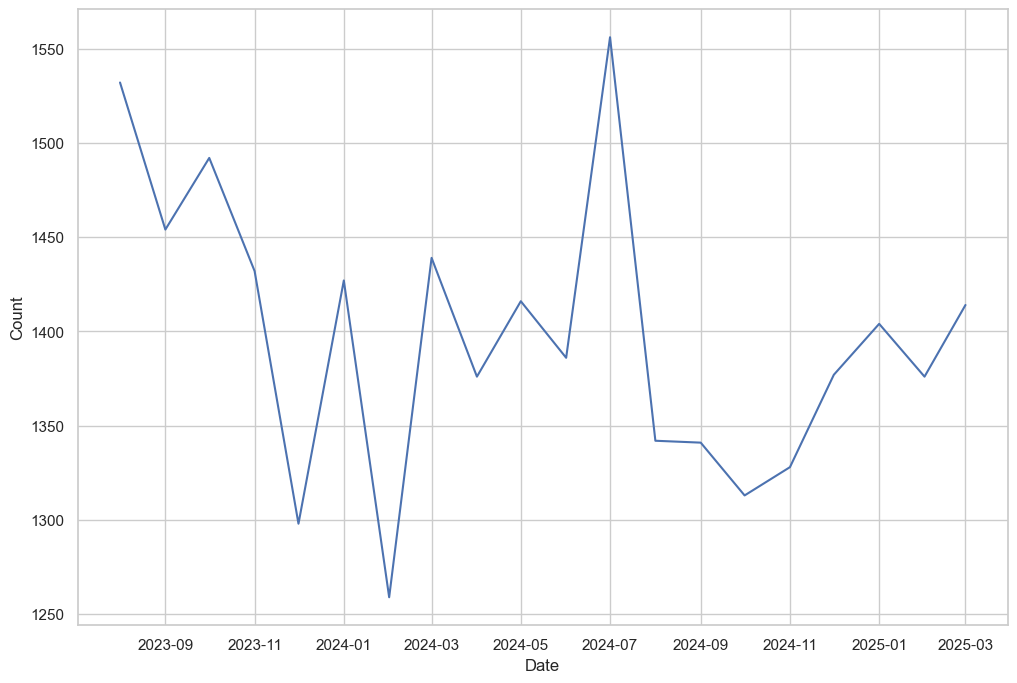

In [129]:
plt.figure(figsize=(12,8))
sns.lineplot(MCSLC_grouped,x='Date',y='Count')

In [130]:
MCSLC_grouped['MCSLC'] = np.where(MCSLC_grouped['Date'] >= '2024-08-01',True,False)
MCSLC_grouped

,Month,Year,Count,Date,MCSLC
0,1,2024,1427,2024-01-01,False
1,1,2025,1404,2025-01-01,True
2,2,2024,1259,2024-02-01,False
3,2,2025,1376,2025-02-01,True
4,3,2024,1439,2024-03-01,False
5,3,2025,1414,2025-03-01,True
6,4,2024,1376,2024-04-01,False
7,5,2024,1416,2024-05-01,False
8,6,2024,1386,2024-06-01,False
9,7,2024,1556,2024-07-01,False


Now I wanted to see if the call volume by day was significantly different pre and post MCSLC

In [131]:
grouped = data.groupby(['Call_Date', 'Call_Hour_Group']).size().reset_index(name='Call_Count')

# Step 2: Separate into groups
before = MCSLC_grouped[MCSLC_grouped['MCSLC'] == False]['Count'].values
after = MCSLC_grouped[MCSLC_grouped['MCSLC'] == True]['Count'].values


# Step 4: Bootstrap both groups
boot_before = bootstrap_means(before)
boot_after = bootstrap_means(after)

In [132]:
t_stat, p_val = ttest_ind(boot_before, boot_after, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 73.535, P-value: 0.000


In [133]:
np.mean(boot_after), np.mean(boot_before)

(1361.525375, 1422.2501666666665)

<Axes: xlabel='Date', ylabel='Count'>

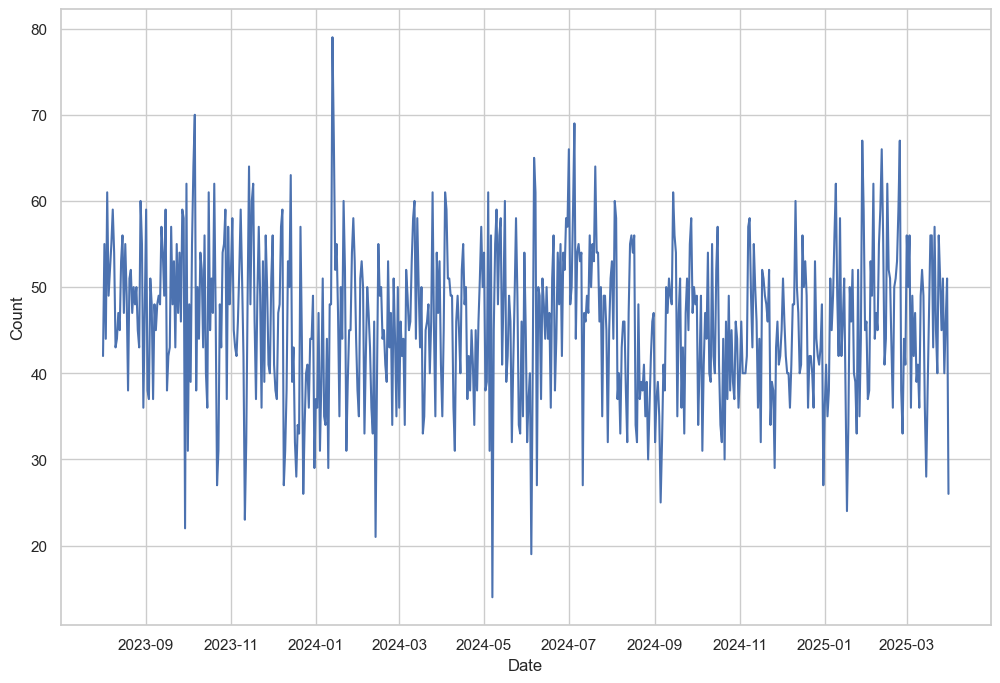

In [134]:
MCSLC_day = MCSLC_compare.groupby('Call_Date').size().reset_index()
MCSLC_day.columns = ['Date','Count']
MCSLC_day['MCSLC'] = np.where(MCSLC_day['Date'] >= '2024-08-01',True,False)
plt.figure(figsize=(12,8))
sns.lineplot(MCSLC_day,x='Date',y='Count')

In [135]:
grouped = data.groupby(['Call_Date', 'Call_Hour_Group']).size().reset_index(name='Call_Count')

# Step 2: Separate into groups
before = MCSLC_day[MCSLC_day['MCSLC'] == False]['Count'].values
after = MCSLC_day[MCSLC_day['MCSLC'] == True]['Count'].values


# Step 4: Bootstrap both groups
boot_before = bootstrap_means(before)
boot_after = bootstrap_means(after)

In [136]:
t_stat, p_val = ttest_ind(boot_before, boot_after, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 77.132, P-value: 0.000


In [137]:
np.mean(boot_after), np.mean(boot_before)

(44.85995884773662, 46.63473770491803)

Using a difference in differences test to measure the impact of MCSLC on CAHOOOTS call volume

In [138]:
MCSLC_day

,Date,Count,MCSLC
0,2023-08-01,42,False
1,2023-08-02,55,False
2,2023-08-03,44,False
3,2023-08-04,61,False
4,2023-08-05,49,False
...,...,...,...
604,2025-03-27,51,True
605,2025-03-28,40,True
606,2025-03-29,46,True
607,2025-03-30,51,True


In [139]:


policy_date = '2024-08-01'  # set this as the actual cutoff if different
MCSLC_day['Post'] = MCSLC_day['Date'] > policy_date

MCSLC_day['Did'] = MCSLC_day['MCSLC'] & MCSLC_day['Post']


In [140]:
import statsmodels.formula.api as smf

before = MCSLC_day[MCSLC_day['MCSLC'] == False]['Count'].values
after = MCSLC_day[MCSLC_day['MCSLC'] == True]['Count'].values


boot_before = bootstrap_means(before)
boot_after = bootstrap_means(after)

boot_df = pd.DataFrame({
    'Count': np.concatenate([boot_before, boot_after]),
    'Post': [False] * len(boot_before) + [True] * len(boot_after)
})

model = smf.ols('Count ~ Post', data=boot_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     6780.
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:26:26   Log-Likelihood:                -1423.6
No. Observations:                2000   AIC:                             2851.
Df Residuals:                    1998   BIC:                             2862.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       46.6297      0.016   2989.243   

Using the DiD test you can see that the there is significant data that shows the introduction of MCSLC reduced the call volume of cahoots calls by about 0.85 calls a day

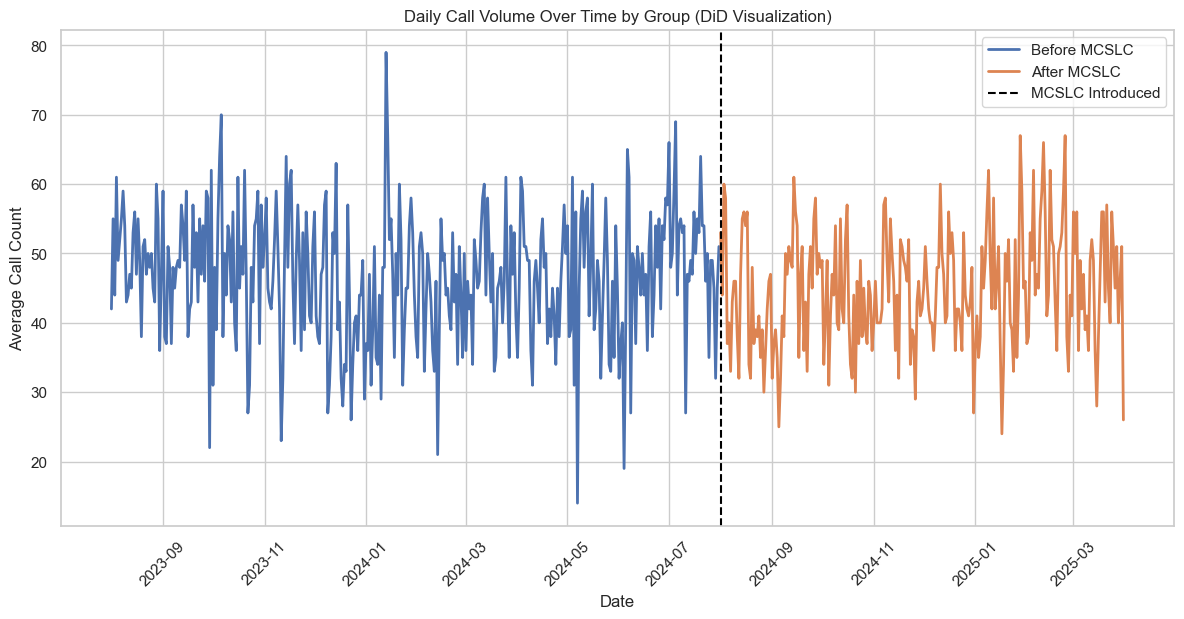

In [141]:

# Load the data (mocked here as the actual DataFrame is already named MCSLC_day)
# We'll use the existing MCSLC_day DataFrame which includes Date, Count, MCSLC, and Post

# Step 1: Create a treatment status label for plotting
MCSLC_day['Group'] = MCSLC_day['MCSLC'].map({True: 'After MCSLC', False: 'Before MCSLC'})

# Step 2: Average daily counts over time for each group
daily_avg = MCSLC_day.groupby(['Date', 'Group'])['Count'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg, x='Date', y='Count', hue='Group', linewidth=2)

# Highlight policy date
policy_date = pd.to_datetime('2024-08-01')
plt.axvline(policy_date, color='black', linestyle='--', label='MCSLC Introduced')

# Labels and title
plt.title('Daily Call Volume Over Time by Group (DiD Visualization)')
plt.xlabel('Date')
plt.ylabel('Average Call Count')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


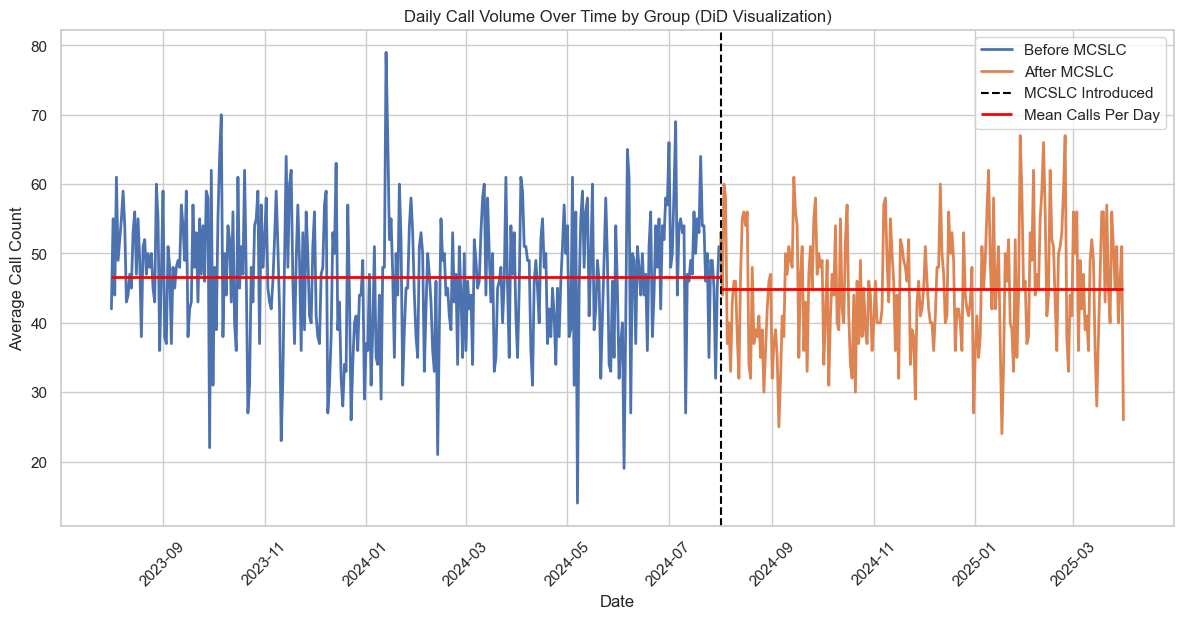

In [142]:
# Step 1: Create a treatment status label for plotting
MCSLC_day['Group'] = MCSLC_day['MCSLC'].map({True: 'After MCSLC', False: 'Before MCSLC'})

# Step 2: Average daily counts over time for each group
daily_avg = MCSLC_day.groupby(['Date', 'Group'])['Count'].mean().reset_index()

# Step 3: Compute policy date and means
policy_date = pd.to_datetime('2024-08-01')
before_mean = MCSLC_day[MCSLC_day['Group'] == 'Before MCSLC']['Count'].mean()
after_mean = MCSLC_day[MCSLC_day['Group'] == 'After MCSLC']['Count'].mean()

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg, x='Date', y='Count', hue='Group', linewidth=2)

# Add vertical policy date
plt.axvline(policy_date, color='black', linestyle='--', label='MCSLC Introduced')

# Add horizontal mean lines only within correct date ranges
plt.hlines(before_mean, xmin=daily_avg['Date'].min(), xmax=policy_date,
           colors='red', linewidth=2)

plt.hlines(after_mean, xmin=policy_date, xmax=daily_avg['Date'].max(),
           colors='Red', linewidth=2, label='Mean Calls Per Day')

# Final plot formatting
plt.title('Daily Call Volume Over Time by Group (DiD Visualization)')
plt.xlabel('Date')
plt.ylabel('Average Call Count')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


Seeing the difference in differences per month before and after MCSLC

In [143]:
import statsmodels.formula.api as smf

before = MCSLC_grouped[MCSLC_grouped['MCSLC'] == False]['Count'].values
after = MCSLC_grouped[MCSLC_grouped['MCSLC'] == True]['Count'].values


boot_before = bootstrap_means(before)
boot_after = bootstrap_means(after)

boot_df = pd.DataFrame({
    'Count': np.concatenate([boot_before, boot_after]),
    'Post': [False] * len(boot_before) + [True] * len(boot_after)
})

model = smf.ols('Count ~ Post', data=boot_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     4770.
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:26:29   Log-Likelihood:                -8781.2
No. Observations:                2000   AIC:                         1.757e+04
Df Residuals:                    1998   BIC:                         1.758e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1422.6422      0.618   2303.036   

Significant and calls are being reduced by about 32.5 calls a month

In [144]:
MCSLC_grouped

,Month,Year,Count,Date,MCSLC
0,1,2024,1427,2024-01-01,False
1,1,2025,1404,2025-01-01,True
2,2,2024,1259,2024-02-01,False
3,2,2025,1376,2025-02-01,True
4,3,2024,1439,2024-03-01,False
5,3,2025,1414,2025-03-01,True
6,4,2024,1376,2024-04-01,False
7,5,2024,1416,2024-05-01,False
8,6,2024,1386,2024-06-01,False
9,7,2024,1556,2024-07-01,False


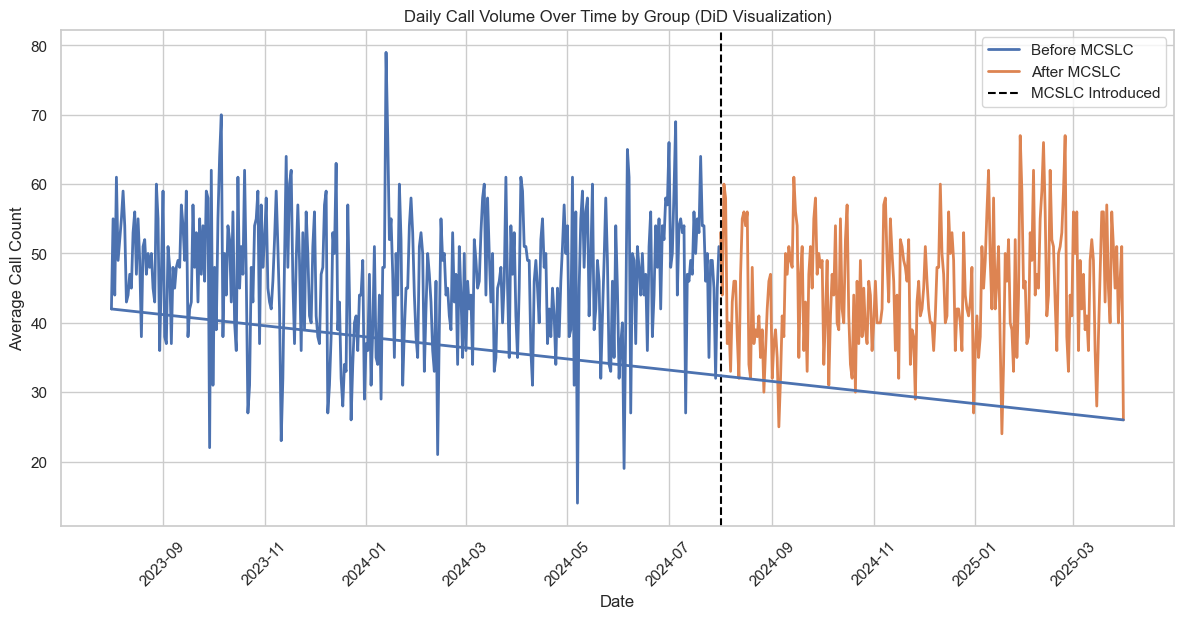

In [145]:
# Step 1: Plot the main lines
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg, x='Date', y='Count', hue='Group', linewidth=2)

# Step 2: Add policy date vertical line
policy_date = pd.to_datetime('2024-08-01')
plt.axvline(policy_date, color='black', linestyle='--', label='MCSLC Introduced')

# Step 3: Get endpoints
before = daily_avg[daily_avg['Group'] == 'Before MCSLC'].sort_values('Date')
after = daily_avg[daily_avg['Group'] == 'After MCSLC'].sort_values('Date')

# Step 4: Plot a connecting line
plt.plot(
    [before['Date'].min(), after['Date'].max()],
    [before[before['Date'] == before['Date'].min()]['Count'].values[0],
     after[after['Date'] == after['Date'].max()]['Count'].values[0]],
    color='#4C72B0', linewidth=2,
)

# Labels and formatting
plt.title('Daily Call Volume Over Time by Group (DiD Visualization)')
plt.xlabel('Date')
plt.ylabel('Average Call Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()


In [155]:
daily_avg

,Date,Group,Count
0,2023-08-01,After MCSLC,1532.0
1,2023-09-01,After MCSLC,1454.0
2,2023-10-01,After MCSLC,1492.0
3,2023-11-01,After MCSLC,1432.0
4,2023-12-01,After MCSLC,1298.0
5,2024-01-01,After MCSLC,1427.0
6,2024-02-01,After MCSLC,1259.0
7,2024-03-01,After MCSLC,1439.0
8,2024-04-01,After MCSLC,1376.0
9,2024-05-01,After MCSLC,1416.0


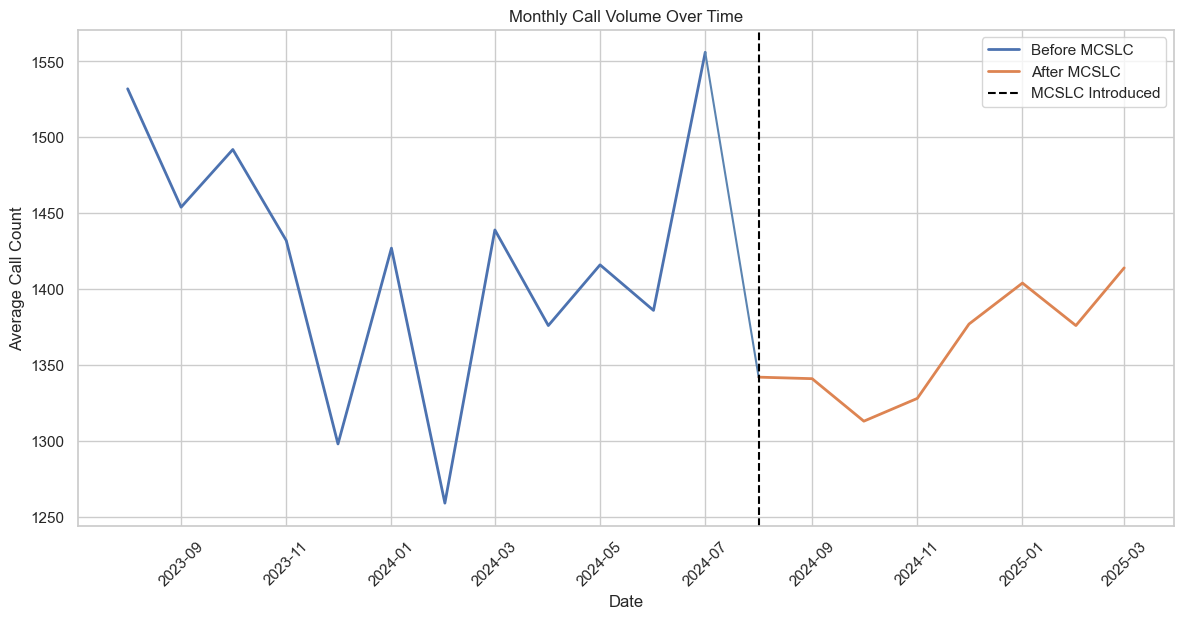

In [164]:
MCSLC_grouped['Group'] = MCSLC_grouped['MCSLC'].map({False: 'Before MCSLC', True: 'After MCSLC'})

# Step 2: Average daily counts over time for each group
daily_avg = MCSLC_grouped.groupby(['Date', 'Group'])['Count'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg, x='Date', y='Count', linewidth=2,hue='Group')

x = [pd.to_datetime('2024-07-01'), pd.to_datetime('2024-08-01')]
y = [daily_avg.loc[daily_avg['Date'] == x[0], 'Count'].values[0],
     daily_avg.loc[daily_avg['Date'] == x[1], 'Count'].values[0]]

plt.plot(x, y, color='#5B84B1')


plt.axvline(policy_date, color='black', linestyle='--', label='MCSLC Introduced')
# Highlight policy date
policy_date = pd.to_datetime('2024-08-01')

# Labels and title
plt.title('Monthly Call Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Call Count')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [147]:
data

,Unnamed: 0,calltime,zip,priority,nature,primeunit,Call_Year,Call_Month,Call_Time,Call_Day,Call_Hour,Call_Hour_Group,Call_Date
0,14,2018-01-01 00:20:49,97401,5,ASSIST PUBLIC,CAHOOT,2018,1,00:20:49,1,0,Night,2018-01-01
1,27,2018-01-01 00:48:34,97402,7,ASSIST PUBLIC,CAHOOT,2018,1,00:48:34,1,0,Night,2018-01-01
2,28,2018-01-01 01:00:06,97401,7,ASSIST PUBLIC,CAHOOT,2018,1,01:00:06,1,1,Night,2018-01-01
3,37,2018-01-01 01:53:28,97402,7,CHECK WELFARE,CAHOOT,2018,1,01:53:28,1,1,Night,2018-01-01
4,38,2018-01-01 01:56:06,97401,7,TRANSPORT,CAHOOT,2018,1,01:56:06,1,1,Night,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182576,1488507,2016-12-31 21:16:44,97401,7,TRANSPORT,CAHOOT,2016,12,21:16:44,6,21,Evening,2016-12-31
182577,1488522,2016-12-31 21:55:13,97401,7,TRANSPORT,CAHOOT,2016,12,21:55:13,6,21,Evening,2016-12-31
182578,1488557,2016-12-31 23:17:05,97402,5,CHECK WELFARE,CAHOOT,2016,12,23:17:05,6,23,Night,2016-12-31
182579,1488574,2016-12-31 23:55:57,97401,7,ASSIST PUBLIC,CAHOOT,2016,12,23:55:57,6,23,Night,2016-12-31


In [148]:
last_5 = data[data['Call_Year'] >= 2020]

In [149]:
average_calls_per_day = last_5.groupby('Call_Date').size().mean()

In [150]:
MCSLC_False = MCSLC_compare[MCSLC_compare['MCSLC'] == False]
MCSLC_True = MCSLC_compare[MCSLC_compare['MCSLC'] == True]


In [151]:
MCSLC_False.groupby('Call_Date').size().mean(), MCSLC_True.groupby('Call_Date').size().mean(), average_calls_per_day

(46.631147540983605, 44.83539094650206, 51.051508844953176)

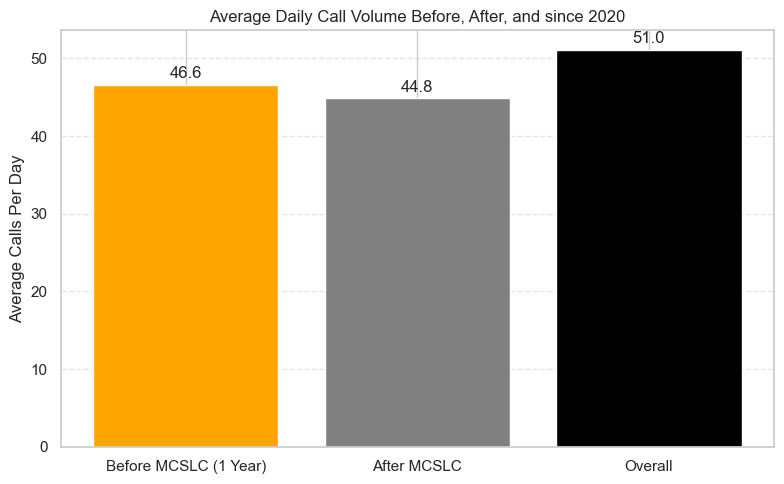

In [152]:
import matplotlib.pyplot as plt

# Your values
before = 46.63
after = 44.84
overall = 51.05

# Data
labels = ['Before MCSLC (1 Year)', 'After MCSLC', 'Overall']
values = [before, after, overall]
colors = ['orange', 'gray', 'black']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom')

# Labels and title
plt.ylabel('Average Calls Per Day')
plt.title('Average Daily Call Volume Before, After, and since 2020')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
